In [33]:
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [50]:
def collect_data(root_dir):
    """
    Collects and processes energy and magnetization data from CSV files organized in subdirectories by temperature (T) and lattice size (L).

    Args:
        root_dir (str): Path to the main directory containing subdirectories named "T = {number}".

    Returns:
        dict: A nested dictionary where data[T][L] contains 'energy' and 'magnetization' arrays averaged over blocks of 100.
    """
    data = defaultdict(dict)  # data[T][L] = {'energy': ..., 'magnetization': ...}

    # Iterate over each subdirectory (T folders) in root_dir
    for t_entry in os.scandir(root_dir):
        if t_entry.is_dir() and t_entry.name.startswith('T='):
            # Extract T value
            print(f"Found Dir:{t_entry}")
            t_str = t_entry.name.split('=')[1].strip()
            try:
                T = float(t_str)
            except ValueError:
                print(f"Skipping invalid T folder: {t_entry.name}")
                continue

            # Process each CSV file in the T folder
            for l_entry in os.scandir(t_entry.path):
                if l_entry.is_file() and l_entry.name.endswith('.csv'):
                    # Extract L value from filename
                    l_filename = l_entry.name
                    l_str = l_filename.split('L=')[1].split('.')[0].strip()
                    print(l_str)
                    try:
                        L = int(l_str)
                    except ValueError:
                        print(f"Skipping invalid L file: {l_filename}")
                        continue

                    # Read CSV data, skipping the first row
                    try:
                        data_csv = np.genfromtxt(l_entry.path, delimiter=',', skip_header=1)
                    except Exception as e:
                        print(f"Error reading {l_entry.path}: {e}")
                        continue

                    # Check data shape
                    if data_csv.ndim != 2 or data_csv.shape[1] != 2:
                        print(f"File {l_entry.path} has invalid shape {data_csv.shape}. Skipping.")
                        continue

                    energy = data_csv[:, 0]
                    magnetization = data_csv[:, 1]
                    
                    # Store in data structure
                    data[T][L] = {
                        'energy': energy,
                        'magnetization': magnetization
                    }

    return data

In [91]:
# Example usage:
data = collect_data(os.getcwd() + "//thermal_averaging_data")


Found Dir:<DirEntry 'T=1.6000000000000005'>
32
16
8
64
Found Dir:<DirEntry 'T=3.1999999999999966'>
8
32
64
16
Found Dir:<DirEntry 'T=1.05'>
16
64
32
8
Found Dir:<DirEntry 'T=2.25'>
32
64
8
16
Found Dir:<DirEntry 'T=3.099999999999997'>
8
32
64
16
Found Dir:<DirEntry 'T=3.4499999999999957'>
8
32
16
64
Found Dir:<DirEntry 'T=2.3'>
64
16
32
8
Found Dir:<DirEntry 'T=2.9999999999999973'>
32
64
8
16
Found Dir:<DirEntry 'T=2.2'>
64
16
32
8
Found Dir:<DirEntry 'T=2.1500000000000004'>
16
64
32
8
Found Dir:<DirEntry 'T=3.399999999999996'>
32
64
8
16
Found Dir:<DirEntry 'T=2.3999999999999995'>
32
64
8
16
Found Dir:<DirEntry 'T=3.349999999999996'>
16
8
64
32
Found Dir:<DirEntry 'T=1.7500000000000007'>
32
8
64
16
Found Dir:<DirEntry 'T=1.8500000000000008'>
16
64
8
32
Found Dir:<DirEntry 'T=2.799999999999998'>
64
16
32
8
Found Dir:<DirEntry 'T=1.5000000000000004'>
32
64
8
16
Found Dir:<DirEntry 'T=1.2000000000000002'>
8
32
64
16
Found Dir:<DirEntry 'T=1.4000000000000004'>
64
16
32
8
Found Dir:<DirEnt

0.20506392045454547


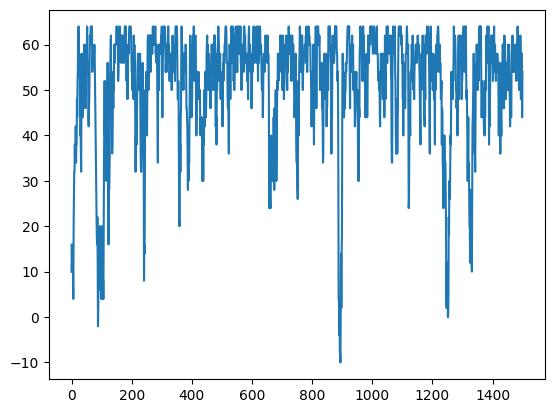

In [92]:
plt.plot(data[2.2][8]['magnetization'][:])
print(np.mean(data[2.2][8]['magnetization'][400:])/(16**2))

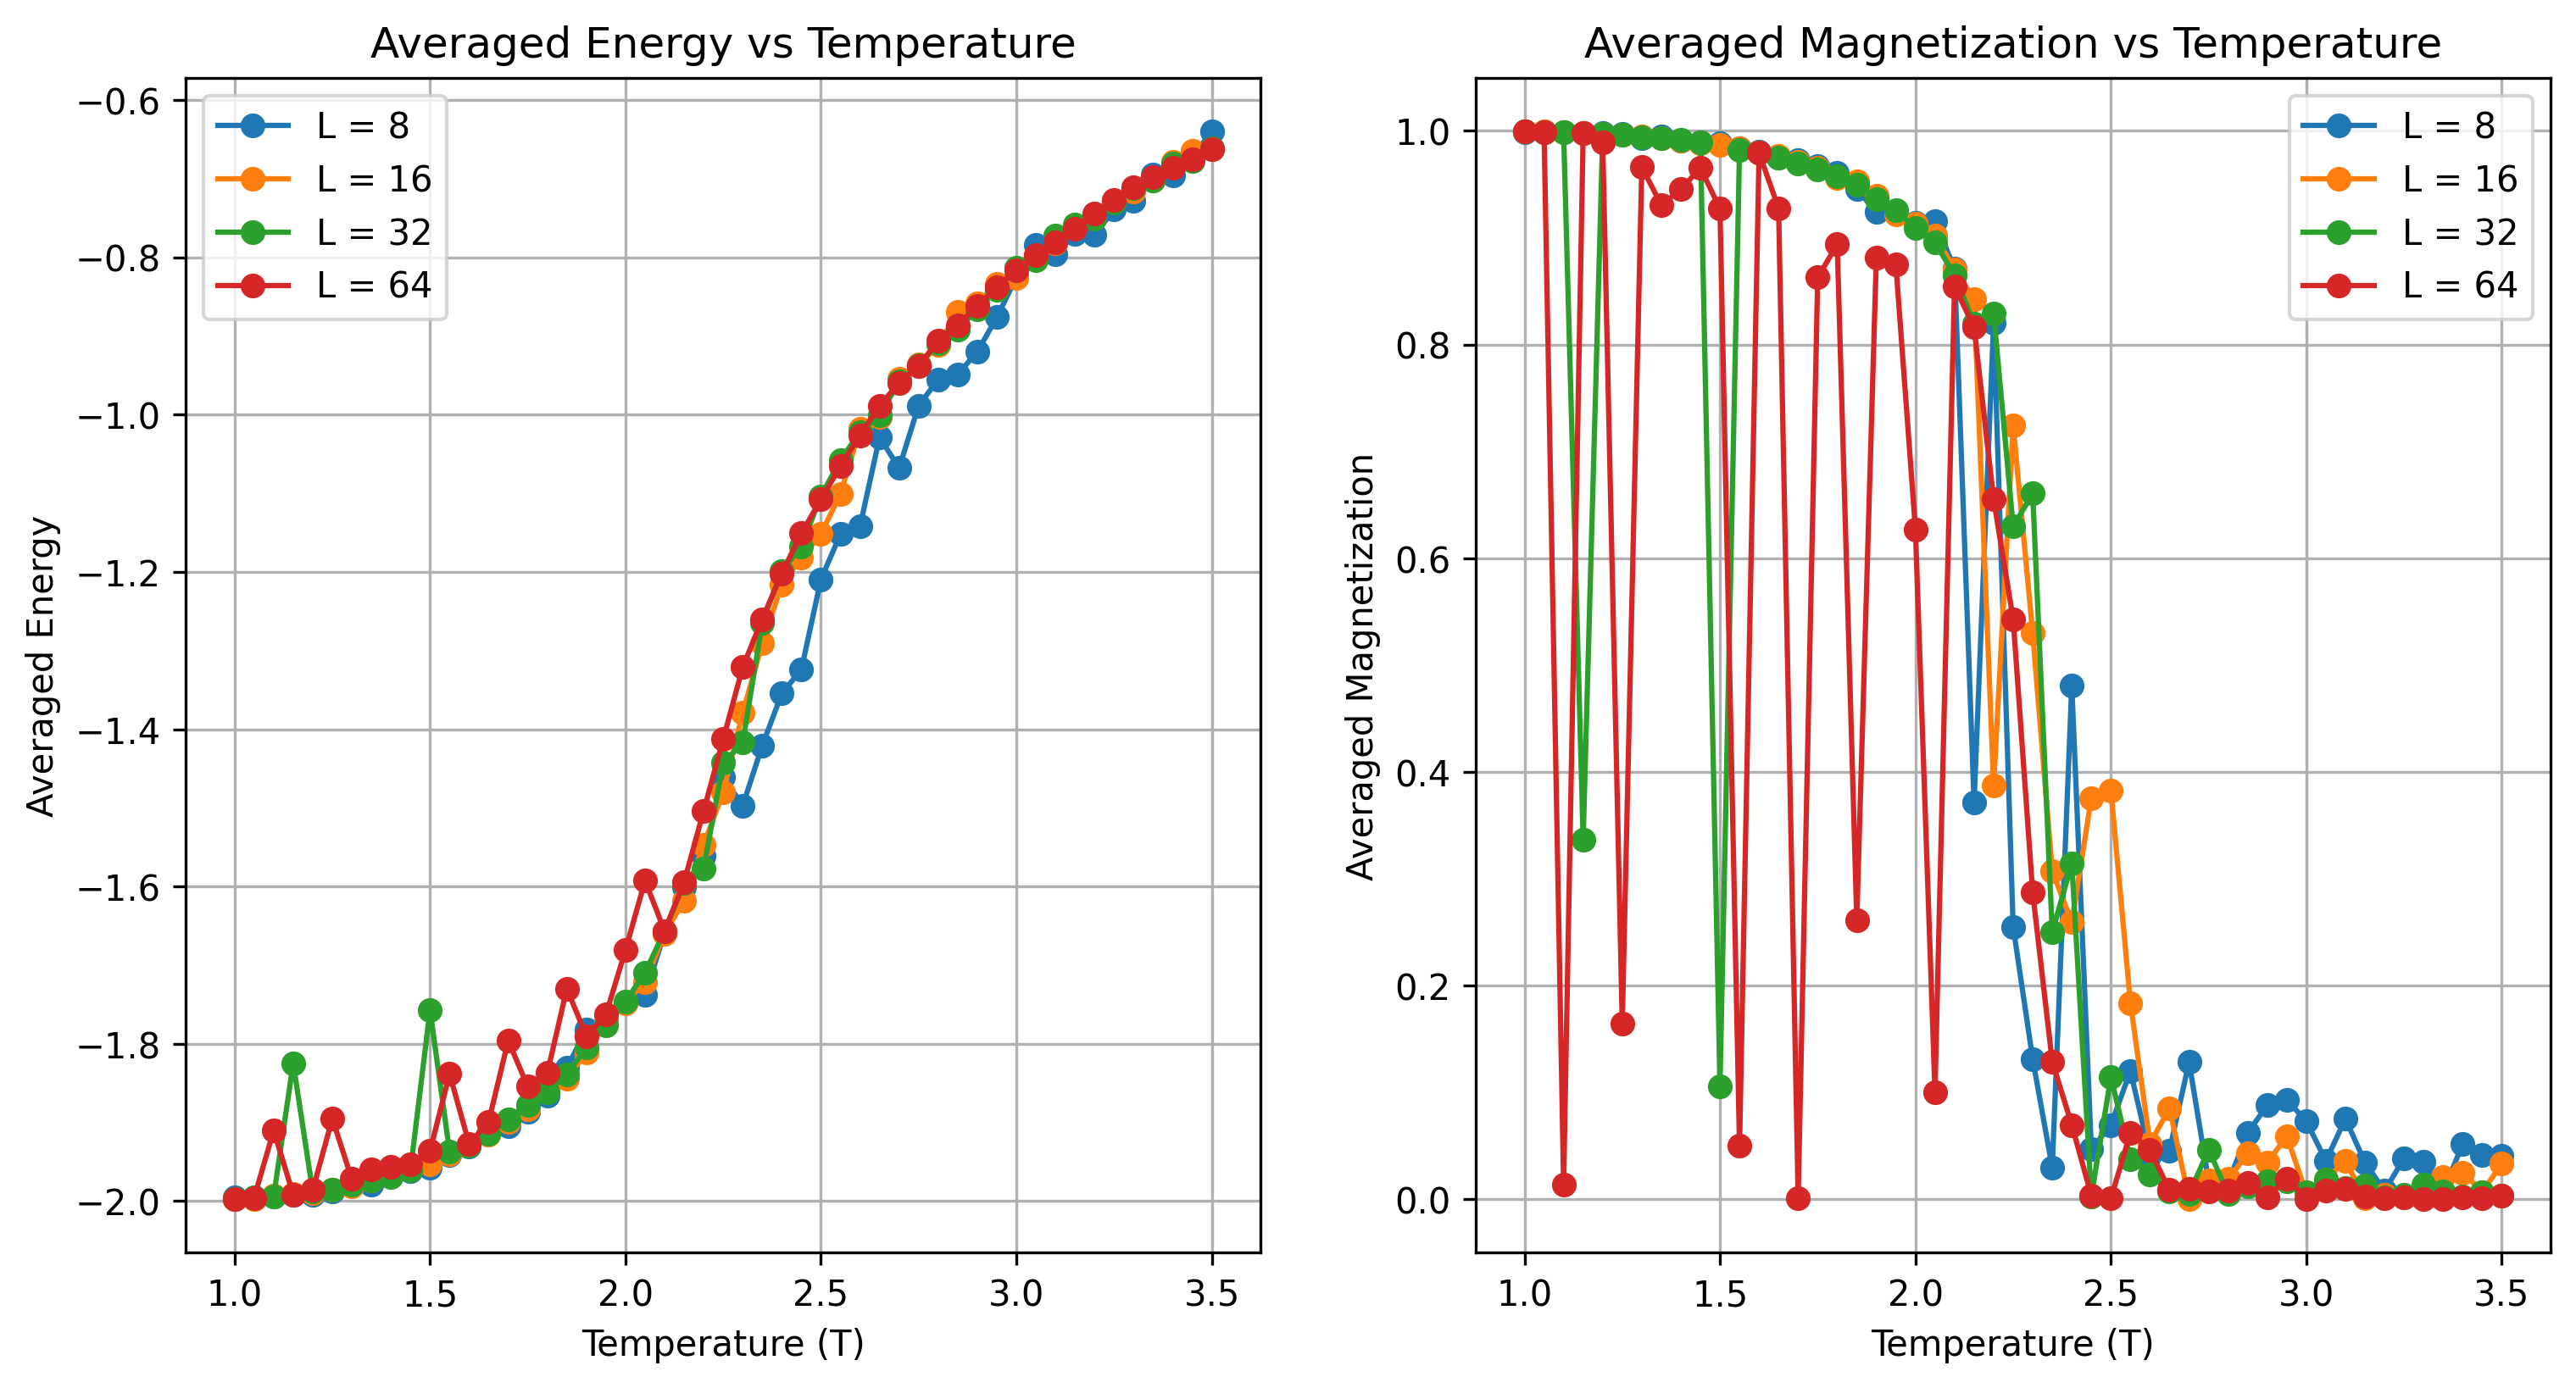

In [ ]:
# Data[T][L]["energy", "magnetization"]
# - each index is a set of averaged temperatures
n_min = 400
# Extract unique lattice sizes (L) from the data
lattice_sizes = set()
for T in data:
    lattice_sizes.update(data[T].keys())
lattice_sizes = sorted(lattice_sizes)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,6), dpi = 300)
fig2, ax3 = plt.subplots(nrows=1, ncols=1, figsize = (6,6), dpi = 300)
# Create a plot for each lattice size
for L in lattice_sizes:
    temperatures = []
    energies = []
    magnetizations = []

    energy_variance = []
    magnet_variance = []

    # Collect data for this lattice size
    for T in sorted(data.keys()):
        if L in data[T]:
            temperatures.append(T)
            # <E>
            energies.append(np.mean(data[T][L]['energy'][n_min:]))  # Use mean of averaged energy
            # <M>
            magnetizations.append(np.mean(data[T][L]['magnetization'][n_min:]))  # Use mean of averaged energy
            # <E^2>
            energy_variance.append(np.mean(np.array(data[T][L]['energy'][n_min:])**2))
            # <M^2>
            magnet_variance.append(np.mean(np.array(data[T][L]['magnetization'][n_min:])**2))

    # Plot energy vs temperature for this lattice size
    ax1.plot(temperatures, np.array(energies)/L**2, marker='o', label=f'L = {L}')
    ax2.plot(temperatures, np.abs(np.array(magnetizations))/(L**2), marker='o', label=f'L = {L}')
    ax3.plot(temperatures, (np.array(energy_variance) - np.array(energies)**2)/L**2, marker='o', label=f'Heat Capacity L = {L}')
    ax3.plot(temperatures, (np.array(magnet_variance) - np.array(magnetizations)**2)/L**2, marker='o', label=f'Susceptibility L = {L}')

# Add labels and legend
ax1.set_xlabel('Temperature (T)')
ax1.set_ylabel('Averaged Energy')
ax1.set_title('Averaged Energy vs Temperature')
ax1.legend()
ax1.grid(True)

# Add labels and legend
ax2.set_xlabel('Temperature (T)')
ax2.set_ylabel('Averaged Magnetization')
ax2.set_title('Averaged Magnetization vs Temperature')
ax2.legend()
ax2.grid(True)

# Add labels and legend
ax3.set_xlabel('Temperature (T)')
ax3.set_title('Heat Capacity, Susceptibility')
ax3.legend()
ax3.grid(True)

plt.show()